In [15]:
%matplotlib inline
from functional_alignment.fastSRM import FastSRM
from glob import glob
from nilearn.datasets import fetch_atlas_basc_multiscale_2015
import numpy as np
from nilearn.input_data import MultiNiftiMasker
from nilearn import plotting
import nilearn
import matplotlib.pyplot as plt

In [4]:
# Fetch data (here sherlock dataset which where subjects where watching an episode of the BBC TV show sherlock)
subjects = ["10", "11", "12"]
sessions = ["00", "01"]
files = np.array(
    [["/storage/workspace/hrichard/sherlock_data/%s_sherlock_movie_s%s.nii" % (session, subject)
      for session in sessions]
     for subject in subjects]
)
# shape of input files is n_subjects, n_sessions
files

array([['/storage/workspace/hrichard/sherlock_data/00_sherlock_movie_s10.nii',
        '/storage/workspace/hrichard/sherlock_data/01_sherlock_movie_s10.nii'],
       ['/storage/workspace/hrichard/sherlock_data/00_sherlock_movie_s11.nii',
        '/storage/workspace/hrichard/sherlock_data/01_sherlock_movie_s11.nii'],
       ['/storage/workspace/hrichard/sherlock_data/00_sherlock_movie_s12.nii',
        '/storage/workspace/hrichard/sherlock_data/01_sherlock_movie_s12.nii']],
      dtype='<U67')

In [5]:
# Fetch atlas
fetch_atlas_basc_multiscale_2015(data_dir="../data/")
name_atlas = 'template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale444.nii.gz'
atlas_path = '../data/basc_multiscale_2015/' + name_atlas

In [17]:
# Introducing fastSRM+
srm = FastSRM(n_components=5, 
              atlas=atlas_path,
              temp_dir="../temp_dir",
              verbose=1,
              standardize=True,
              detrend=True,
              smoothing_fwhm=5,
              t_r=2,
              low_pass=0.1,
              high_pass=0.01,
              memory_level=5,
              memory="/storage/tompouce/hrichard/general_cache/",
              n_jobs=1,
              mask_strategy="epi",
              mask='/home/parietal/hrichard/cogspaces_data/mask/hcp_mask.nii.gz'
             )

In [18]:
# We fit all subjects for session 1
%time srm.fit(files[:, 0])

/home/parietal/hrichard/hugo-richard-M2/retreat/venv/lib/python3.5/site-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/storage/tompouce/hrichard/general_cache/'", use "location='/storage/tompouce/hrichard/general_cache/'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)


[MultiNiftiMasker.fit] Loading data from None
[MultiNiftiMasker.transform] Resampling mask
[FastSRM.fit] Reducing data


/home/parietal/hrichard/hugo-richard-M2/retreat/venv/lib/python3.5/site-packages/nilearn/_utils/cache_mixin.py:232: DeprecationWarning: The 'cachedir' attribute has been deprecated in version 0.12 and will be removed in version 0.14.
Use os.path.join(memory.location, 'joblib') attribute instead.
  if (memory.cachedir is None and memory_level is not None


[FastSRM.fit] Finds shared response using reduced data
[FastSRM.fit] Finds basis using full data and shared response
CPU times: user 3min 44s, sys: 11.6 s, total: 3min 56s
Wall time: 3min 56s


FastSRM(atlas='../data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale444.nii.gz',
    detrend=True, high_pass=0.01, low_pass=0.1,
    mask='/home/parietal/hrichard/cogspaces_data/mask/hcp_mask.nii.gz',
    mask_args=None, mask_strategy='epi',
    memory='/storage/tompouce/hrichard/general_cache/', memory_level=5,
    n_components=5, n_iter=10, n_jobs=1, n_reduced_dimensions=300,
    random_state=None, smoothing_fwhm=5, standardize=True, t_r=2,
    target_affine=None, target_shape=None, temp_dir='../temp_dir',
    verbose=1)

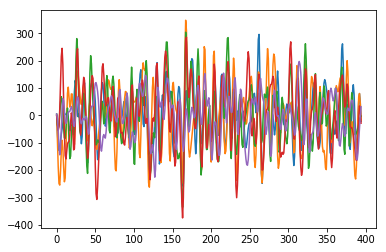

In [20]:
shared = srm.transform(files[:-1, 1])
# shared is a list of length 'number of sessions used for training' of np array of shape n_timeframes, n_components
plt.plot(shared[0])

In [21]:
X_pred = srm.inverse_transform(shared, subjects_indexes=[2])[0]
masker = MultiNiftiMasker(
    verbose=1,
    standardize=True,
    detrend=True,
    smoothing_fwhm=5,
    t_r=2,
    low_pass=0.1,
    high_pass=0.01,
    memory_level=5,
    memory="/storage/tompouce/hrichard/general_cache/",
    n_jobs=1,
    mask_strategy="epi",
    mask_img='/home/parietal/hrichard/cogspaces_data/mask/hcp_mask.nii.gz').fit()
diff = X_pred - masker.transform(files[-1, -1])
res = 1 - diff.var(axis=0)

[MultiNiftiMasker.fit] Loading data from None
[MultiNiftiMasker.transform] Resampling mask


/home/parietal/hrichard/hugo-richard-M2/retreat/venv/lib/python3.5/site-packages/nilearn/_utils/cache_mixin.py:84: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='/storage/tompouce/hrichard/general_cache/'", use "location='/storage/tompouce/hrichard/general_cache/'" instead.
  memory = Memory(cachedir=cache_dir, verbose=verbose)


________________________________________________________________________________
[Memory] Calling nilearn.masking.unmask...
unmask(array([0.090071, ..., 0.26625 ]), <nibabel.nifti1.Nifti1Image object at 0x7f10d2063f60>)
___________________________________________________________unmask - 0.2s, 0.0min


/home/parietal/hrichard/hugo-richard-M2/retreat/venv/lib/python3.5/site-packages/scipy/ndimage/measurements.py:272: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  return _nd_image.find_objects(input, max_label)


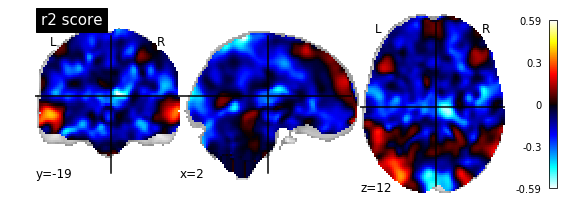

In [22]:
plotting.plot_stat_map(masker.inverse_transform(res),
                       title="r2 score"
                       
                      )